## Importing functions

In [31]:
import os
import pandas as pd
import zipfile
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import fuzz, process
import folium


# Functions to load the data

In [32]:
data_folder = "data"

# 1. Load bus routes data from CSV file
def load_bus_routes_data():
    bus_routes_path = os.path.join(data_folder, "bus_routes_data.csv")
    if os.path.exists(bus_routes_path):
        bus_routes_df = pd.read_csv(bus_routes_path)
        return bus_routes_df
    else:
        print(f"Error: {bus_routes_path} not found.")
        return None

# 2. Load bus stops data from CSV file and convert to GeoDataFrame
def load_bus_stops_data():
    bus_stops_path = os.path.join(data_folder, "bus_stops_data.csv")
    if os.path.exists(bus_stops_path):
        bus_stops_df = pd.read_csv(bus_stops_path)
        # Create a GeoDataFrame for bus stops with Point geometries from Longitude and Latitude
        bus_stops_gdf = gpd.GeoDataFrame(
            bus_stops_df,
            geometry=gpd.points_from_xy(bus_stops_df['Longitude'], bus_stops_df['Latitude']),
            crs='EPSG:4326'
        )
        print("Bus Stops Data Loaded and converted to GeoDataFrame.")
        return bus_stops_gdf
    else:
        print(f"Error: {bus_stops_path} not found.")
        return None

# 3. Load Passenger Volume by Bus Stops data from ZIP file
def load_passenger_volume_bus_stops():
    zip_path = os.path.join(data_folder, "transport_node_bus_202408.zip")
    csv_file_name = "transport_node_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                passenger_volume_df = pd.read_csv(csv_file)
                print("Passenger Volume by Bus Stops Data Loaded.")
                return passenger_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None

# 4. Load Origin-Destination Bus Stops data from ZIP file
def load_od_volume_bus_stops():
    zip_path = os.path.join(data_folder, "origin_destination_bus_202408.zip")
    csv_file_name = "origin_destination_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                od_volume_df = pd.read_csv(csv_file)
                print("Origin-Destination Bus Stops Data Loaded.")
                return od_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None
    
# 5. Load MRT exits data from ZIP file
def load_mrt_exits_shapefile():
    zip_path = os.path.join('data', "train_station_exit_geospatial_whole_island_202408.zip")
    shapefile_components = [
        'TrainStationExit/Train_Station_Exit_Layer.shp',
        'TrainStationExit/Train_Station_Exit_Layer.dbf',
        'TrainStationExit/Train_Station_Exit_Layer.shx'
    ]

    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        
            temp_dir = 'temp_shapefile'  # Temporary folder for extraction
            os.makedirs(temp_dir, exist_ok=True)
            
            # Extract necessary shapefile components
            for component in shapefile_components:
                zip_ref.extract(component, path=temp_dir)

            # Load the shapefile into a GeoDataFrame
            shapefile_path = os.path.join(temp_dir, 'TrainStationExit', 'Train_Station_Exit_Layer.shp')
            gdf_exits = gpd.read_file(shapefile_path)

            # Clean up extracted files and temporary directory
            for component in shapefile_components:
                os.remove(os.path.join(temp_dir, component))
            
            # Remove the empty directory
            try:
                os.rmdir(os.path.join(temp_dir, 'TrainStationExit'))
                os.rmdir(temp_dir)
            except OSError as e:
                print(f"Warning: {e.strerror} - {e.filename}")
            
            print("MRT Exits data loaded.")
            
            # Display the columns (fields) and first few rows in the shapefile
            print("Columns in MRT Exits Shapefile:")
            print(gdf_exits.columns)
            print("\nFirst 5 rows of data:")
            print(gdf_exits.head())
            
            return gdf_exits
    else:
        print(f"Error: {zip_path} not found.")
        return None
    
# 6. Load mrtlines data
def load_mrt_lines_mapping():
    mrt_lines_path = os.path.join(data_folder, "singapore_mrt_stations_with_lines_filtered.csv")
    if os.path.exists(mrt_lines_path):
        mrt_lines_df = pd.read_csv(mrt_lines_path)
        return mrt_lines_df
    else:
        print(f"Error: {mrt_lines_path} not found.")
    

## Loading the Data

In [41]:
# Load datasets
bus_routes_df = load_bus_routes_data()
bus_stops_gdf = load_bus_stops_data()
passenger_volume_df = load_passenger_volume_bus_stops()
od_volume_df = load_od_volume_bus_stops()
mrt_exits_gdf = load_mrt_exits_shapefile()
mrt_lines_mapping = load_mrt_lines_mapping()

# Ensure that the data is being loaded correctly
if bus_routes_df is not None:
    print(f"Bus Routes DataFrame shape: {bus_routes_df.shape}")
if bus_stops_gdf is not None:
    print(f"Bus Stops GeoDataFrame shape: {bus_stops_gdf.shape}")
if passenger_volume_df is not None:
    print(f"Passenger Volume DataFrame shape: {passenger_volume_df.shape}")
if od_volume_df is not None:
    print(f"Origin-Destination Bus Stops DataFrame shape: {od_volume_df.shape}")
if mrt_exits_gdf is not None:
    print(f"MRT Exits GeoDataFrame shape: {mrt_exits_gdf.shape}")
if mrt_lines_mapping is not None:
    print(f"MRT Lines Mapping DataFrame shape: {mrt_lines_mapping.shape}")

bus_routes_df.head()

Bus Stops Data Loaded and converted to GeoDataFrame.
Passenger Volume by Bus Stops Data Loaded.
Origin-Destination Bus Stops Data Loaded.
MRT Exits data loaded.
Columns in MRT Exits Shapefile:
Index(['stn_name', 'exit_code', 'geometry'], dtype='object')

First 5 rows of data:
                 stn_name exit_code                     geometry
0  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)
1  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)
2  MACPHERSON MRT STATION    Exit C  POINT (34337.292 34190.603)
3    TONGKANG LRT STATION    Exit B  POINT (33872.145 41256.053)
4    TONGKANG LRT STATION    Exit A  POINT (33858.542 41234.065)
Bus Routes DataFrame shape: (25500, 12)
Bus Stops GeoDataFrame shape: (5137, 6)
Passenger Volume DataFrame shape: (199800, 7)
Origin-Destination Bus Stops DataFrame shape: (5760081, 7)
MRT Exits GeoDataFrame shape: (593, 3)
MRT Lines Mapping DataFrame shape: (186, 10)


,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance,WD_FirstBus,WD_LastBus,SAT_FirstBus,SAT_LastBus,SUN_FirstBus,SUN_LastBus
0,10,SBST,1,1,75009,0.0,0500,2300,0500,2300,0500,2300
1,10,SBST,1,2,76059,0.6,0502,2302,0502,2302,0502,2302
2,10,SBST,1,3,76069,1.1,0504,2304,0504,2304,0503,2304
3,10,SBST,1,4,96289,2.3,0508,2308,0508,2309,0507,2308
4,10,SBST,1,5,96109,2.7,0509,2310,0509,2311,0508,2309


## Tagging bus stops to MRT Exit
We need to identify the bus stops that are linked to the MRT exits. There are 2 main ways to approach this:
1. String matching based on description
   1. We attempted this method and found that while it worked for most of the stations, it still caught on to alot of false positives. One false positive example is 'Carltex Stn', which is not a train station.
2. Distance matching based on MRT exits

## Tagging MRT Exits to MRT Stations
We will now determine which MRT station and MRT line does each exit belong to. We need to note that they may not always contain the exact match of the MRT station name. So we will use a fuzzy matching approach to find the closest match

Filter out the words MRT Station
If there is LRT, also filter out the whole thing

In [34]:
# Function to filter out "LRT", remove "MRT STATION", fuzzy match, and join MRT lines, then drop unwanted columns
def match_mrt_line_to_exits(mrt_lines_mapping, mrt_exits_gdf, threshold=50):
    # Step 1: Filter out rows containing "LRT" in the station name
    mrt_exits_gdf = mrt_exits_gdf[~mrt_exits_gdf['stn_name'].str.contains('LRT', case=False)]
    
    # Step 2: Remove "MRT STATION" from 'stn_name' before matching
    mrt_exits_gdf['stn_name_cleaned'] = mrt_exits_gdf['stn_name'].str.replace('MRT STATION', '', case=False).str.strip()

    # Step 3: Perform fuzzy matching and create a new column for the best matched station name
    # Get the MRT station names in lowercase for case-insensitive matching
    mrt_station_names = mrt_lines_mapping['Station name_English • Malay'].str.lower().tolist()
    
    matched_station_names = []  # List to store matched station names

    for idx, row in mrt_exits_gdf.iterrows():
        exit_description = row['stn_name_cleaned'].lower()  # Lowercase the cleaned station name for case-insensitive matching
        
        # Perform fuzzy matching to find the closest MRT station name
        match_result = process.extractOne(exit_description, mrt_station_names, scorer=fuzz.token_sort_ratio)
        
        if match_result:
            match, score, _ = match_result
            if score >= threshold:
                matched_station_names.append(match)
            else:
                matched_station_names.append(None)
        else:
            matched_station_names.append(None)
    
    # Add the matched station names to the GeoDataFrame as a new column
    mrt_exits_gdf['stn_name_matched'] = matched_station_names
    
    # Step 4: Perform a left join to the MRT lines mapping DataFrame
    # Standardize the MRT station names to lowercase for the merge
    mrt_lines_mapping['Station name_English • Malay'] = mrt_lines_mapping['Station name_English • Malay'].str.lower()

    # Left join based on the matched station names
    mrt_exits_gdf = mrt_exits_gdf.merge(mrt_lines_mapping, 
                                        left_on='stn_name_matched', 
                                        right_on='Station name_English • Malay', 
                                        how='left')

    # Step 5: Drop the unnecessary columns
    cols_to_drop = ['Matched_MRT_Line', 'stn_name_cleaned', 'MRT_Lines']
    mrt_exits_gdf.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    return mrt_exits_gdf

# Example of calling the function
mrt_exits_gdf_mapped = match_mrt_line_to_exits(mrt_lines_mapping, mrt_exits_gdf)

# Display the updated DataFrame
print(mrt_exits_gdf_mapped.head())


                 stn_name exit_code                     geometry  \
0  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)   
1  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)   
2  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)   
3  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)   
4  MACPHERSON MRT STATION    Exit C  POINT (34337.292 34190.603)   

  stn_name_matched Station name_English • Malay  NS  EW  DT  CC  NE  TE  CG  \
0       macpherson                   macpherson   0   0   1   1   0   0   0   
1       macpherson                   macpherson   0   0   1   1   0   0   0   
2       macpherson                   macpherson   0   0   1   1   0   0   0   
3       macpherson                   macpherson   0   0   1   1   0   0   0   
4       macpherson                   macpherson   0   0   1   1   0   0   0   

   CE  
0   0  
1   0  
2   0  
3   0  
4   0  


/Users/zhanheng/Public/github/project/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/zhanheng/Public/github/project/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Optimal Distance
In reality, we believe that bus stops less than 1 MRT distance away from MRT stations are considered MRT Bus Stops. 

So to find the optimal distance, we check the bus routes to find the average distance between two bus stops, excluding the outliers.

  ServiceNo  Direction  MeanDistanceBetweenStops
0        10          1                432.876712
1        10          2                436.986301
2       100          1                441.071429
3       100          2                439.622642
4      100A          1                400.000000


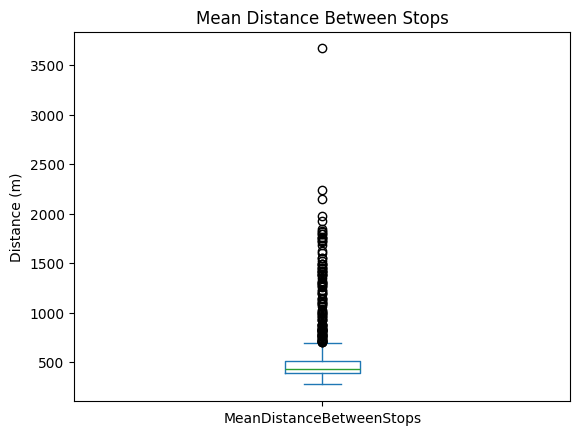

Some outliers:
    ServiceNo  Direction  MeanDistanceBetweenStops   z_score
572      858B          1               3670.000000  9.367749
466       661          2               2245.454545  5.087032
465       661          1               2150.000000  4.800194
449       651          2               1976.923077  4.280103
407       513          1               1930.769231  4.141412
Number of outliers: 21


In [35]:
# Step 1: Sort by ServiceNo, Direction, and StopSequence to ensure the order is correct
bus_routes_df_sorted = bus_routes_df.sort_values(by=['ServiceNo', 'Direction', 'StopSequence'])

# Step 2: Calculate the difference in Distance between consecutive stops for each ServiceNo and Direction
bus_routes_df_sorted['DistanceBetweenStops'] = bus_routes_df_sorted.groupby(['ServiceNo', 'Direction'])['Distance'].diff()

# Step 3: Calculate the mean distance between stops for each bus route (ServiceNo and Direction)
mean_distance_between_stops = bus_routes_df_sorted.groupby(['ServiceNo', 'Direction'])['DistanceBetweenStops'].mean().reset_index()

# Rename the column for clarity
mean_distance_between_stops.rename(columns={'DistanceBetweenStops': 'MeanDistanceBetweenStops'}, inplace=True)

mean_distance_between_stops['MeanDistanceBetweenStops'] = mean_distance_between_stops['MeanDistanceBetweenStops'] * 1000

# Display the result
print(mean_distance_between_stops.head())

# Examine the outliers
mean_distance_between_stops['MeanDistanceBetweenStops'].plot(kind='box')
plt.title('Mean Distance Between Stops')
plt.ylabel('Distance (m)')
plt.show()

# Put the outliers in a df, using z-score
mean_distance_between_stops['z_score'] = np.abs((mean_distance_between_stops['MeanDistanceBetweenStops'] - mean_distance_between_stops['MeanDistanceBetweenStops'].mean()) / mean_distance_between_stops['MeanDistanceBetweenStops'].std())
outliers = mean_distance_between_stops[mean_distance_between_stops['z_score'] > 3]
outliers = outliers.sort_values(by='MeanDistanceBetweenStops', ascending=False)
print("Some outliers:")
print(outliers.head())
print("Number of outliers:", outliers.shape[0])


From the data above, we can see that most of the buses that have a relatively long distance are those with express services (those that travel the expressway). So to handle these data, we will just filter out the outliers.

In [36]:
#Filter out the outliers based on the boxplot
mean_distance_between_stops_filtered = mean_distance_between_stops[mean_distance_between_stops['z_score'] <= 3]
true_mean_distance = mean_distance_between_stops_filtered['MeanDistanceBetweenStops'].mean()
print(f"Mean Distance between stops after filtering: {true_mean_distance:.2f} m")


Mean Distance between stops after filtering: 512.75 m


Using the optimal distance found, we can assume that bus stops within 1 MRT station can be tagged as a MRT bus stop. So presumably, if the bus stop is ~500m away from the MRT, technically we can assume that it is sufficiently close to walk to a MRT station.

In [37]:
# Function to tag bus stops with MRT proximity and include MRT line indicators
def tagging_mrt_to_bus_stops(y, x, distance=true_mean_distance):
    # Set CRS if not already defined
    if y.crs is None:
        y = y.set_crs(epsg=3414)  # Use SVY21 (Singapore)
    if x.crs is None:
        x = x.set_crs(epsg=3414)  # WGS84 for bus stops

    # Re-project MRT exits to EPSG:4326 (WGS84) to match bus stops
    y = y.to_crs(epsg=3414)

    projected_crs = "EPSG:3857"  # Mercator projection in meters
    y_projected = y.to_crs(projected_crs)
    x_projected = x.to_crs(projected_crs)

    # Perform a spatial join to find the nearest bus stop for each MRT exit
    nearest_bus_stops = gpd.sjoin_nearest(
        y_projected, 
        x_projected, 
        how="left", 
        distance_col="distance"  # Create a column for the distance between the points
    )
    
    # Filter based on the specified distance to ensure we're tagging bus stops correctly
    nearest_bus_stops_filtered = nearest_bus_stops[nearest_bus_stops['distance'] <= distance]

    # Tag bus stops that are within the specified distance as MRT-related
    x['is_mrt'] = x_projected.index.isin(nearest_bus_stops_filtered['index_right'])

    # Perform a normal left merge to bring in MRT line information and matched MRT station
    # We use `BusStopCode` and `index_right` to perform the merge
    merged = x.merge(nearest_bus_stops_filtered[['stn_name_matched', 'NS', 'EW', 'DT', 'CC', 'NE', 'TE', 'CG', 'CE', 'index_right', 'distance']],
                     left_index=True, right_on='index_right', 
                     how='left')

    merged = merged.rename(columns={
        'geometry_x': 'geometry_bus',
        'geometry_y': 'geometry_mrt'
    })
    
    # Filter out duplicate BusStopCode entries
    merged = merged.drop_duplicates(subset='BusStopCode')

    return merged

# Call the function with the MRT exits and bus stops GeoDataFrames
tagging = tagging_mrt_to_bus_stops(mrt_exits_gdf_mapped, bus_stops_gdf, true_mean_distance)

# Filter only the MRT-related bus stops
bus_stops_mrt = tagging[tagging['is_mrt'] == True]

print(bus_stops_mrt.head())
bus_stops_mrt


       BusStopCode     RoadName              Description  Latitude  \
277.0         1059  Victoria St         Bugis Stn Exit B  1.300757   
271.0         1112  Victoria St     Opp Bugis Stn Exit C  1.300092   
279.0         1113  Victoria St         Bugis Stn Exit A  1.301173   
344.0         1319   Kallang Rd  Lavender Stn Exit A/ICA  1.307574   
472.0         1541    Rochor Rd         Bugis Stn Exit D  1.298865   

        Longitude                   geometry  is_mrt stn_name_matched   NS  \
277.0  103.856110  POINT (103.85611 1.30076)    True            bugis  0.0   
271.0  103.855200   POINT (103.8552 1.30009)    True            bugis  0.0   
279.0  103.856114  POINT (103.85611 1.30117)    True            bugis  0.0   
344.0  103.863256  POINT (103.86326 1.30757)    True         lavender  0.0   
472.0  103.857346  POINT (103.85735 1.29886)    True            bugis  0.0   

        EW   DT   CC   NE   TE   CG   CE  index_right   distance  
277.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   

,BusStopCode,RoadName,Description,Latitude,Longitude,geometry,is_mrt,stn_name_matched,NS,EW,DT,CC,NE,TE,CG,CE,index_right,distance
277.0,1059,Victoria St,Bugis Stn Exit B,1.300757,103.856110,POINT (103.85611 1.30076),True,bugis,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5,25.341418
271.0,1112,Victoria St,Opp Bugis Stn Exit C,1.300092,103.855200,POINT (103.8552 1.30009),True,bugis,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,7,54.864321
279.0,1113,Victoria St,Bugis Stn Exit A,1.301173,103.856114,POINT (103.85611 1.30117),True,bugis,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8,21.424779
344.0,1319,Kallang Rd,Lavender Stn Exit A/ICA,1.307574,103.863256,POINT (103.86326 1.30757),True,lavender,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19,50.925420
472.0,1541,Rochor Rd,Bugis Stn Exit D,1.298865,103.857346,POINT (103.85735 1.29886),True,bugis,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,32,56.002992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410.0,95129,PTB2 Basement,Changi Airport Ter 2,1.355093,103.989220,POINT (103.98922 1.35509),True,changi airport,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4935,139.159048
431.0,96041,Upp Changi Rd East,Upp Changi Stn/Opp SUTD,1.341552,103.961237,POINT (103.96124 1.34155),True,upper changi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4958,35.933334
390.0,96049,Upp Changi Rd East,Upp Changi Stn/SUTD,1.340874,103.961433,POINT (103.96143 1.34087),True,upper changi,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4959,43.562840
470.0,96169,Simei St 3,Simei Stn,1.342262,103.953466,POINT (103.95347 1.34226),True,simei,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4983,59.329046


### Checking MRT stops
Just for future debugging, ensuring that our works are correct. We can consider using this for our frontend too

In [40]:
sg_map = folium.Map(location=[1.38, 103.8], zoom_start=12)

for idx, row in bus_stops_mrt.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['Description'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(sg_map)

sg_map